**Reinforcement Learning with TensorFlow & TRFL: Retrace**

Outline:
1. Taxi Environment
* Retrace(λ)
* Taxi with trfl.retrace_core()



In [0]:
#TRFL works with TensorFlow 1.12
#installs TensorFlow version 1.12 then restarts the runtime
!pip install tensorflow==1.12

import os
os.kill(os.getpid(), 9)

    100% |████████████████████████████████| 83.1MB 367kB/s 
    100% |████████████████████████████████| 3.1MB 9.9MB/s 
  Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1


In [0]:
#install tensorflow-probability 0.5.0 that works with TensorFlow 1.12
!pip install tensorflow-probability==0.5.0

#install TRFL
!pip install trfl==1.0

    100% |████████████████████████████████| 686kB 21.2MB/s 
  Found existing installation: tensorflow-probability 0.6.0
    Uninstalling tensorflow-probability-0.6.0:
      Successfully uninstalled tensorflow-probability-0.6.0
    100% |████████████████████████████████| 81kB 5.0MB/s 


In [0]:
import gym
import tensorflow as tf
import trfl
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

** Taxi Environment **

In the Taxi environment (env), the agent uses a taxi (yellow/green if empty/passenger) to try to pick up a passenger at one location (colored blue) and drop the passenger off at another location (colored red). The agent receives a reward for navigating to the goal and using the drop off action. The agent recieves a small negative reward on each step and a large negative reward for incorrectly using pick up and drop off.

In [0]:
env = gym.make('Taxi-v2')
env.reset()
env.render()

for i in range(10):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  env.render()
  if done:
    env.reset()
    
env.close()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B

** Retrace(λ) **

Retrace(λ) “can be seen as an algorithm that automatically adjusts – efficiently and safely – the length of the return to the degree of ”off-policy-ness” (http://incompleteideas.net/book/the-book.html) of any available data. Retrace improves upon similar off-policy methods like importance sampling, Q(λ), and TB(λ). The main benefits of retrace are the low variance, and better usage of off policy and on policy data compared to those methods. Retrace truncates the variance at 1, thus avoiding exploding variance.

** Taxi with Retrace(λ) **


In [0]:
# hyperparameters
episodes = 5000
learning_rate = 0.01
discount = 0.99
lambda_val = 0.90
epsilon_start = 1.0
epsilon_min = 0.02
epsilon_step = (epsilon_start - epsilon_min)/(episodes*.9)

env = gym.make('Taxi-v2')
num_actions = env.action_space.n
stats_every = 100
evaluate_every = 500

tf.reset_default_graph()

# set up input tensors
q_value_ = tf.placeholder(dtype=tf.float32, shape=[None, 1, num_actions], name="q_value")
action_ = tf.placeholder(dtype=tf.int32, shape=[None, 1], name="action")
reward_ = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="reward")
discount_ = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="discount")
target_policy_ = tf.placeholder(dtype=tf.float32, shape=[None, 1, num_actions], name="target_prob")
behaviour_policy_ = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="behaviour_prob")
q_next_ = tf.placeholder(dtype=tf.float32, shape=[None, 1, num_actions], name="q_next")
a_next_ = tf.placeholder(dtype=tf.int32, shape=[None, 1], name="action_next")

# set up TRFL retrace tensor
retrace_return_ = trfl.retrace_core(lambda_=lambda_val, q_tm1=q_value_, a_tm1=action_, r_t=reward_, pcont_t=discount_,
             target_policy_t=target_policy_, behaviour_policy_t=behaviour_policy_, targnet_q_t=q_next_, a_t=a_next_, 
                                    stop_targnet_gradients=True)

** TRFL Usage **

Inputs are largely similar to trfl.q_lambda() and other TRFL Q learning functions. New arguments target_policy_ and behaviour_policy_ are the probabilities of the policy which we wish to learn and the policy the agent behaved with. stop_targnet_gradients stops the gradients from updating the target network (not applicable in this tabular example). trfl.retrace() calls trfl.retrace_core() in a slightly more user friendly way.

In [0]:
# functions for determining target and behaviour probabilities

# target prob: behave greedily at a constant epsilon of the time
def get_target_prob(action_values):
  return get_behaviour_prob(action_values, epsilon=0.01)

# behaviour prob: agent interacts with env by behaving randomly at a non-constant epislon, otherwise greedy
def get_behaviour_prob(action_values, epsilon):
  n_actions = len(action_values)
  # default chance of choosing action is chance of selecting random action divided by number of actions
  action_probs = np.array([epsilon/n_actions]*n_actions)
  
  #greedy actions get remaining action probs, divided between the greedy actions
  max_value = np.max(action_values)
  greedy_actions = len(np.argwhere(action_values == max_value))
  greedy_action_prob = (1. - epsilon)/greedy_actions
  action_probs[np.argwhere(action_values == max_value)] += greedy_action_prob
  
  np.testing.assert_almost_equal(np.sum(action_probs),1.0)
  return action_probs  


In [0]:
stats_list = []
stats_eval_list = []
eval_episode = 0
epsilon = epsilon_start

with tf.Session() as sess:
  action_value_array = np.zeros((env.observation_space.n,num_actions))

  current_state = env.reset()
  current_episode = 1
  q_list, action_list, reward_list, state_int_list, target_prob_list, behaviour_prob_list = [], [], [], [], [], []
  total_reward = 0
  total_len = 0
 
  while current_episode < episodes:
       
    #take epsilon greedy action
    if np.random.rand() < epsilon:
      action = env.action_space.sample()
    else:
      #Choose a greedy action. If multiple greedy actions randomly choose between
      max_actions = np.argwhere(action_value_array[current_state] == np.max(action_value_array[current_state])).reshape((-1))
      action = np.random.choice(max_actions)

    next_state, rew, done, info = env.step(action)
      
    q_list.append(action_value_array[current_state])
    reward_list.append(rew)
    action_list.append(action)
    state_int_list.append(current_state)
    target_prob_list.append(get_target_prob(action_value_array[current_state]))
    behaviour_prob_list.append(get_behaviour_prob(action_value_array[current_state], epsilon)[action])
    
    total_reward += rew
    total_len += 1
    
    if len(q_list) > 1:
      #these arrays use 0 to timestep-1, trfl.retrace() simplifies this compared to trfl.retrace_core()
      q_array = np.array(q_list[:-1]).reshape(-1,1,num_actions)
      a_array = np.array(action_list[:-1]).reshape(-1,1)
      r_array = np.array(reward_list[:-1]).reshape(-1,1)
      #these arrays use 1 to timestep, trfl.retrace() simplifies this compared to trfl.retrace_core()
      q_next_array = np.array(q_list[1:]).reshape(-1,1,num_actions)
      a_next_array = np.array(action_list[1:]).reshape(-1,1)
      target_prob_array = np.array(target_prob_list[1:]).reshape(-1,1,num_actions)
      behaviour_prob_array = np.array(behaviour_prob_list[1:]).reshape(-1,1)
    
      #run TRFL retrace_core tensor to get target values
      retrace_output = sess.run(retrace_return_, feed_dict={
          q_value_:q_array,
          action_:a_array,
          reward_:r_array,
          discount_:np.array([discount]*(len(q_list)-1)).reshape(-1,1),
          target_policy_:target_prob_array,
          behaviour_policy_:behaviour_prob_array,
          q_next_:q_next_array,
          a_next_:a_next_array
        })
      
      #update action values with target values from retrace
      for s, a, target in zip(state_int_list[:-1], action_list[:-1], retrace_output.extra.target.tolist()):
        action_value_array[s,a] += learning_rate*(target[0] - action_value_array[s,a])

    current_state = next_state
    
    if done:   
      if rew == 20:
        success = 1.
      else:
        success = 0.
        
      #decrease epsilon
      epsilon -= epsilon_step
      if epsilon < epsilon_min:
        epsilon = epsilon_min
        
      stats_list.append((current_episode, total_reward, total_len, success))
        
      q_list, action_list, reward_list, state_int_list, target_prob_list, behaviour_prob_list = [], [], [], [], [], []
      total_reward = 0
      total_len = 0
      current_state = env.reset()
      current_episode += 1
        
      if current_episode % stats_every == 0:
        print("Episode {}: Trailing Rew/Len/Success: {:.2f}, {:.2f}, {:.2f}. Epsilon: {:.2f}".format(current_episode, 
                                                                     np.mean(stats_list[-stats_every:],axis=0)[1],
                                                                     np.mean(stats_list[-stats_every:],axis=0)[2],
                                                                     np.mean(stats_list[-stats_every:],axis=0)[3],
                                                                     epsilon))
      # evaluate performance every evaluate_every episodes
      if current_episode % evaluate_every == 0:
        action_array = np.array([*range(num_actions)])
        for i in range(100):
          state = env.reset()
          total_reward = 0
          total_len = 0
          done = 0
          eval_episode += 1
          
          while not done:
            action_prob = get_target_prob(action_value_array[state])
            action = np.random.choice(a=action_array, p=action_prob)
            
            state, rew, done, info = env.step(action)
            total_reward += rew
            total_len += 1
            
            if done:
              if rew == 20:
                success = 1.
              else:
                success = 0.
              stats_eval_list.append((eval_episode, total_reward, total_len, success, current_episode))
        
        print("Evaluation at Episode {}: Avg Rew/Len/Success: {:.2f}, {:.2f}, {:.2f}".format(current_episode, 
                                                                     np.mean(stats_eval_list[-100:],axis=0)[1],
                                                                     np.mean(stats_eval_list[-100:],axis=0)[2],
                                                                     np.mean(stats_eval_list[-100:],axis=0)[3]))
                                                                     
        
        #stop if receiving enough reward
        if len(stats_eval_list) > 100 and np.mean(stats_eval_list[-100:],axis=0)[1] > 8:
              print("Stopping at episode {} with average rewards of {} in 100 evaluation episodes".
                    format(current_episode,np.mean(stats_eval_list[-100:],axis=0)[1]))
              break

        

Episode 100: Trailing Rew/Len/Success: -753.70, 194.73, 0.07. Epsilon: 0.98
Episode 200: Trailing Rew/Len/Success: -710.22, 187.44, 0.10. Epsilon: 0.96
Episode 300: Trailing Rew/Len/Success: -693.34, 186.67, 0.22. Epsilon: 0.93
Episode 400: Trailing Rew/Len/Success: -644.35, 180.16, 0.28. Epsilon: 0.91
Episode 500: Trailing Rew/Len/Success: -543.25, 154.96, 0.56. Epsilon: 0.89
Evaluation at Episode 500: Avg Rew/Len/Success: -10.99, 29.38, 0.91
Episode 600: Trailing Rew/Len/Success: -451.35, 134.82, 0.74. Epsilon: 0.87
Episode 700: Trailing Rew/Len/Success: -386.78, 116.63, 0.88. Epsilon: 0.85
Episode 800: Trailing Rew/Len/Success: -301.01, 97.04, 0.92. Epsilon: 0.83
Episode 900: Trailing Rew/Len/Success: -278.02, 91.57, 0.94. Epsilon: 0.80
Episode 1000: Trailing Rew/Len/Success: -216.20, 76.88, 0.99. Epsilon: 0.78
Evaluation at Episode 1000: Avg Rew/Len/Success: 5.84, 14.50, 0.99
Episode 1100: Trailing Rew/Len/Success: -206.77, 72.07, 0.99. Epsilon: 0.76
Episode 1200: Trailing Rew/Len/

Text(0, 0.5, 'Total Reward')

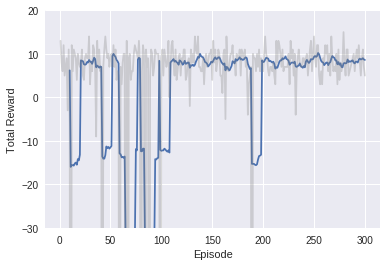

In [0]:
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews, lens, success, train_episode = np.array(stats_eval_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.ylim(-30, 20)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

Text(0, 0.5, 'Episode Length')

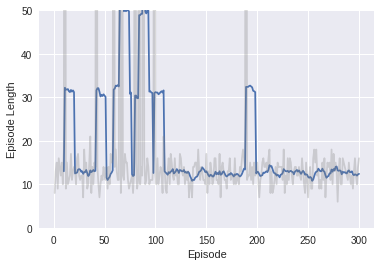

In [0]:
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews, lens, success, train_episode = np.array(stats_eval_list).T
smoothed_lens = running_mean(lens, 10)
plt.plot(eps[-len(smoothed_lens):], smoothed_lens)
plt.plot(eps, lens, color='grey', alpha=0.3)
plt.ylim(0, 50)
plt.xlabel('Episode')
plt.ylabel('Episode Length')
